In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

sns.set(style="whitegrid")

# Record the total flow rate for all time steps
total_list = []

# Read 24 traffic matrices
for i in range(24):
    tm = np.zeros((24, 24))  

    if i < 10:
        file = f'traffic-matrices/IntraTM-2005-01-03-0{i}-00.xml'
    else:
        file = f'traffic-matrices/IntraTM-2005-01-03-{i}-00.xml'

    tree = ET.parse(file)
    root = tree.getroot()

    # Traverse the XML and fill in the tm matrix
    for src in root[1]:
        for dst in src:
            tm[int(src.attrib.get('id'))][int(dst.attrib.get('id'))] = float(dst.text) * 5

    # Calculate total flow
    total_load = np.sum(tm) / 100  # Convert to kbps
    total_list.append(total_load)

# --- Draw a graph of total flow changes ---
tms_24_hours = [i for i in range(24)] 
index_tms = tms_24_hours[13:] + tms_24_hours[:13]

# Get the corresponding TM load
tms_14 = [total_list[i] for i in index_tms]
total_load_tms_14 = [np.array(tm).sum() for tm in tms_14]

# Corrected training set index (corresponding to `tms_24_hours`)
train_hours = [13,15,17,19,20,22,23,0,1,2,4,7,8,9,11]
train_indices = [tms_24_hours.index(h) for h in train_hours]

# Corrected test set index (directly corresponds to `tms_24_hours`)
original_test_indices = [3, 10, 12, 14, 21]
test_indices = [tms_24_hours.index(i) for i in original_test_indices]

# Find TMs that belong to both training and testing
train_set = set(train_indices)
test_set = set(test_indices)
both_set = train_set & test_set
train_only = train_set - both_set
test_only = test_set - both_set

# --- Drawing ---
plt.figure(figsize=(8, 6))

# Training set (blue)
train_only_x = [tms_24_hours[i] for i in train_only]
train_only_y = [total_load_tms_14[i] for i in train_only]
plt.scatter(train_only_x, train_only_y, color="blue", label="training", s=80, alpha=0.8, edgecolors='black')

# Test set (red)
test_only_x = [tms_24_hours[i] for i in test_only]
test_only_y = [total_load_tms_14[i] for i in test_only]
plt.scatter(test_only_x, test_only_y, color="red", label="testing", s=80, alpha=0.8, edgecolors='black')

# Set the X axis to correspond to the correct `tms_24_hours`
plt.xticks(tms_24_hours, fontsize=14)
plt.plot(range(len(total_load_tms_14)), total_load_tms_14, linestyle='-', marker='', color="gray", alpha=0.7)

plt.xlabel("TMs", fontsize=16)
plt.ylabel("Total Load (kbps)", fontsize=16)

ax = plt.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(14)
ax.tick_params(axis='y', labelsize=14)
# legend
plt.legend(prop={'size': 16})
plt.tight_layout
plt.savefig("Figure 7. Traffic demand of 24TM GÉANT topography.svg", format='svg', bbox_inches='tight')


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Show only these specific TMs
tms_24_hours = [i for i in range(24)]
index_tms = tms_24_hours[13:] + tms_24_hours[:13]
selected_indices = [3, 12, 14, 17, 21]
or_selected_indices = [index_tms[i] for i in selected_indices]

rows, cols = 2, 3

# Adjust `figsize` to keep each subfigure square
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

# Flatten into a 1D array for easy looping
axes = axes.flatten()

# Read 24 traffic matrices and draw heatmaps
for i, tm_idx in enumerate(or_selected_indices):
    tm = np.zeros((24, 24))

    if i < 10:
        file = f'traffic-matrices/IntraTM-2005-01-03-0{i}-00.xml'
    else:
        file = f'traffic-matrices/IntraTM-2005-01-03-{i}-00.xml'

    tree = ET.parse(file)
    root = tree.getroot()

    # Traverse the XML and fill in the tm matrix
    for src in root[1]:
        for dst in src:
            tm[int(src.attrib.get('id'))][int(dst.attrib.get('id'))] = float(dst.text) * 5

    # Draw a heat map on the corresponding sub-map
    ax = axes[i]
    sns.heatmap(tm, annot=False, cmap='viridis', cbar=True, ax=ax, square=True)
    ax.set_title(f"TM {selected_indices[i]}", fontsize=16)
    ax.set_xlabel("dst", fontsize=16)
    ax.set_ylabel("src", fontsize=16)

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

# Adjust the layout to ensure that the graphics are not squeezed or deformed
plt.tight_layout()
plt.savefig("Figure 10. Traffic heatmap of the GÉANT testing set.svg", format='svg', bbox_inches='tight')
plt.show()


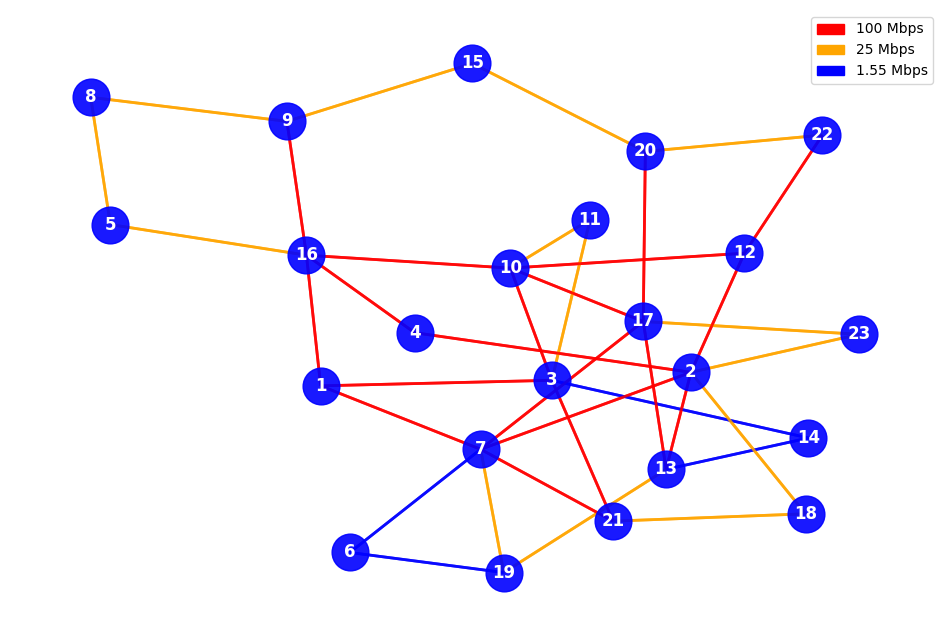

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

with open("../bw_r.txt", "r") as file:
    link_data = file.read()

# Parsing the data and building the NetworkX graph
G = nx.Graph()
edges = []

for line in link_data.strip().split("\n"):
    src, dst, _, capacity = map(float, line.split(","))
    G.add_edge(int(src), int(dst), capacity=capacity)
    edges.append((int(src), int(dst), capacity))

pos = nx.kamada_kawai_layout(G)

pos[2] = (pos[2][0] + 0.05, pos[2][1] + 0.05)
# Define link color changes based on capacity
color_map = []
edge_width = []
for _, _, capacity in edges:
    if capacity >= 100:
        color_map.append("red")
        edge_width.append(2)
    elif capacity >= 25:
        color_map.append("orange")
        edge_width.append(2)
    else:  
        color_map.append("blue")
        edge_width.append(2)

# Draw a topology diagram
plt.figure(figsize=(12, 8))

# Draw Node
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="blue", alpha=0.9)

# Draw edges using custom colors
edges_list = [(src, dst) for src, dst, _ in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges_list, edge_color=color_map, width=edge_width, alpha=0.8)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_color="white", font_weight="bold")

# Legend
legend_patches = [
    mpatches.Patch(color="red", label="100 Mbps"),
    mpatches.Patch(color="orange", label="25 Mbps"),
    mpatches.Patch(color="blue", label="1.55 Mbps")
]
plt.legend(handles=legend_patches, loc="upper right")
plt.grid(False)
plt.axis("off")
plt.show()

import json
with open("pos.json", "w") as f:
    json.dump({k: list(v) for k, v in pos.items()}, f)
